## Predicting NBA Attendance 

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, cross_validate
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import scipy.stats as stats
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

# visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## EDA

In [2]:
nba_team_stats = pd.read_csv('nba_team_stats.csv')

In [3]:
nba_team_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 565 entries, 0 to 564
Data columns (total 49 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Team                   565 non-null    object 
 1   Year                   565 non-null    int64  
 2   MP                     565 non-null    float64
 3   FG                     565 non-null    float64
 4   FGA                    565 non-null    float64
 5   FG%                    565 non-null    float64
 6   3P                     565 non-null    float64
 7   3PA                    565 non-null    float64
 8   3P%                    565 non-null    float64
 9   2P                     565 non-null    float64
 10  2PA                    565 non-null    float64
 11  2P%                    565 non-null    float64
 12  FT                     565 non-null    float64
 13  FTA                    565 non-null    float64
 14  FT%                    565 non-null    float64
 15  ORB   

In [4]:
# Convert attendance from object to int.
nba_team_stats['ATTENDANCE'] = nba_team_stats['ATTENDANCE'].str.replace(',','').astype(int)

In [5]:
nba_team_stats['Team'].unique()

array(['BOS', 'TOR', 'NYK', 'PHI', 'CLE', 'MIL', 'CHI', 'IND', 'DET',
       'ORL', 'ATL', 'MIA', 'WAS', 'DEN', 'UTA', 'POR', 'SEA', 'OKC',
       'MIN', 'LAL', 'PHO', 'LAC', 'GSW', 'SAC', 'DAL', 'SAS', 'HOU',
       'VAN', 'MEM', 'NJN', 'BRK', 'CHH', 'NOH', 'NOK', 'NOP', 'CHA',
       'CHO'], dtype=object)

In [6]:
nba_team_stats

,Team,Year,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,FT/FGA,OEFG%,OTOV%,ODRB%,OFT/FGA,ARENA,ATTENDANCE,CAPACITY,ATTENDANCE_PER_GAME,%_ATTENDANCE/CAPACITY
0,BOS,2000,240.6,37.2,83.9,0.444,5.1,15.4,0.331,32.2,...,0.236,0.498,15.8,73.8,0.306,FleetCenter,683608,18624,16673,0.90
1,BOS,2001,241.8,33.8,79.1,0.428,7.2,19.9,0.363,26.6,...,0.250,0.493,16.0,72.7,0.256,FleetCenter,629201,18624,15346,0.82
2,BOS,2002,241.8,34.8,82.1,0.424,8.5,23.7,0.359,26.3,...,0.223,0.464,15.1,72.9,0.245,FleetCenter,659751,18624,16091,0.86
3,BOS,2003,241.8,32.9,79.4,0.415,8.8,26.3,0.334,24.2,...,0.227,0.471,15.1,72.5,0.242,FleetCenter,709049,18624,17294,0.93
4,BOS,2004,240.3,34.7,78.2,0.443,6.7,19.5,0.346,27.9,...,0.245,0.479,15.7,69.5,0.240,FleetCenter,664248,18624,16201,0.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,CHO,2015,242.7,35.5,84.5,0.420,6.1,19.1,0.318,29.5,...,0.202,0.487,12.0,79.3,0.188,Time Warner Cable Arena,704886,19077,17192,0.90
561,CHO,2016,242.1,37.0,84.4,0.439,10.6,29.4,0.362,26.4,...,0.222,0.496,12.5,79.8,0.191,Time Warner Cable Arena,716894,19077,17485,0.92
562,CHO,2017,241.8,37.7,85.4,0.442,10.0,28.6,0.351,27.7,...,0.227,0.523,12.1,79.6,0.164,Spectrum Center,710643,19077,17333,0.91
563,CHO,2018,241.2,39.0,86.7,0.450,10.0,27.2,0.369,28.9,...,0.233,0.532,12.4,80.7,0.165,Spectrum Center,671404,19077,16376,0.86


In [7]:
# Domain Knowledge: Selecting features that we believe are relevant to attendance numbers.

dk_nba_team_stats = nba_team_stats[{'FG','FG%', '3P', '3P%', 'PTS', 'WINS', 
                                    'MOV', 'ORTG', 'ATTENDANCE', '%_ATTENDANCE/CAPACITY'}]

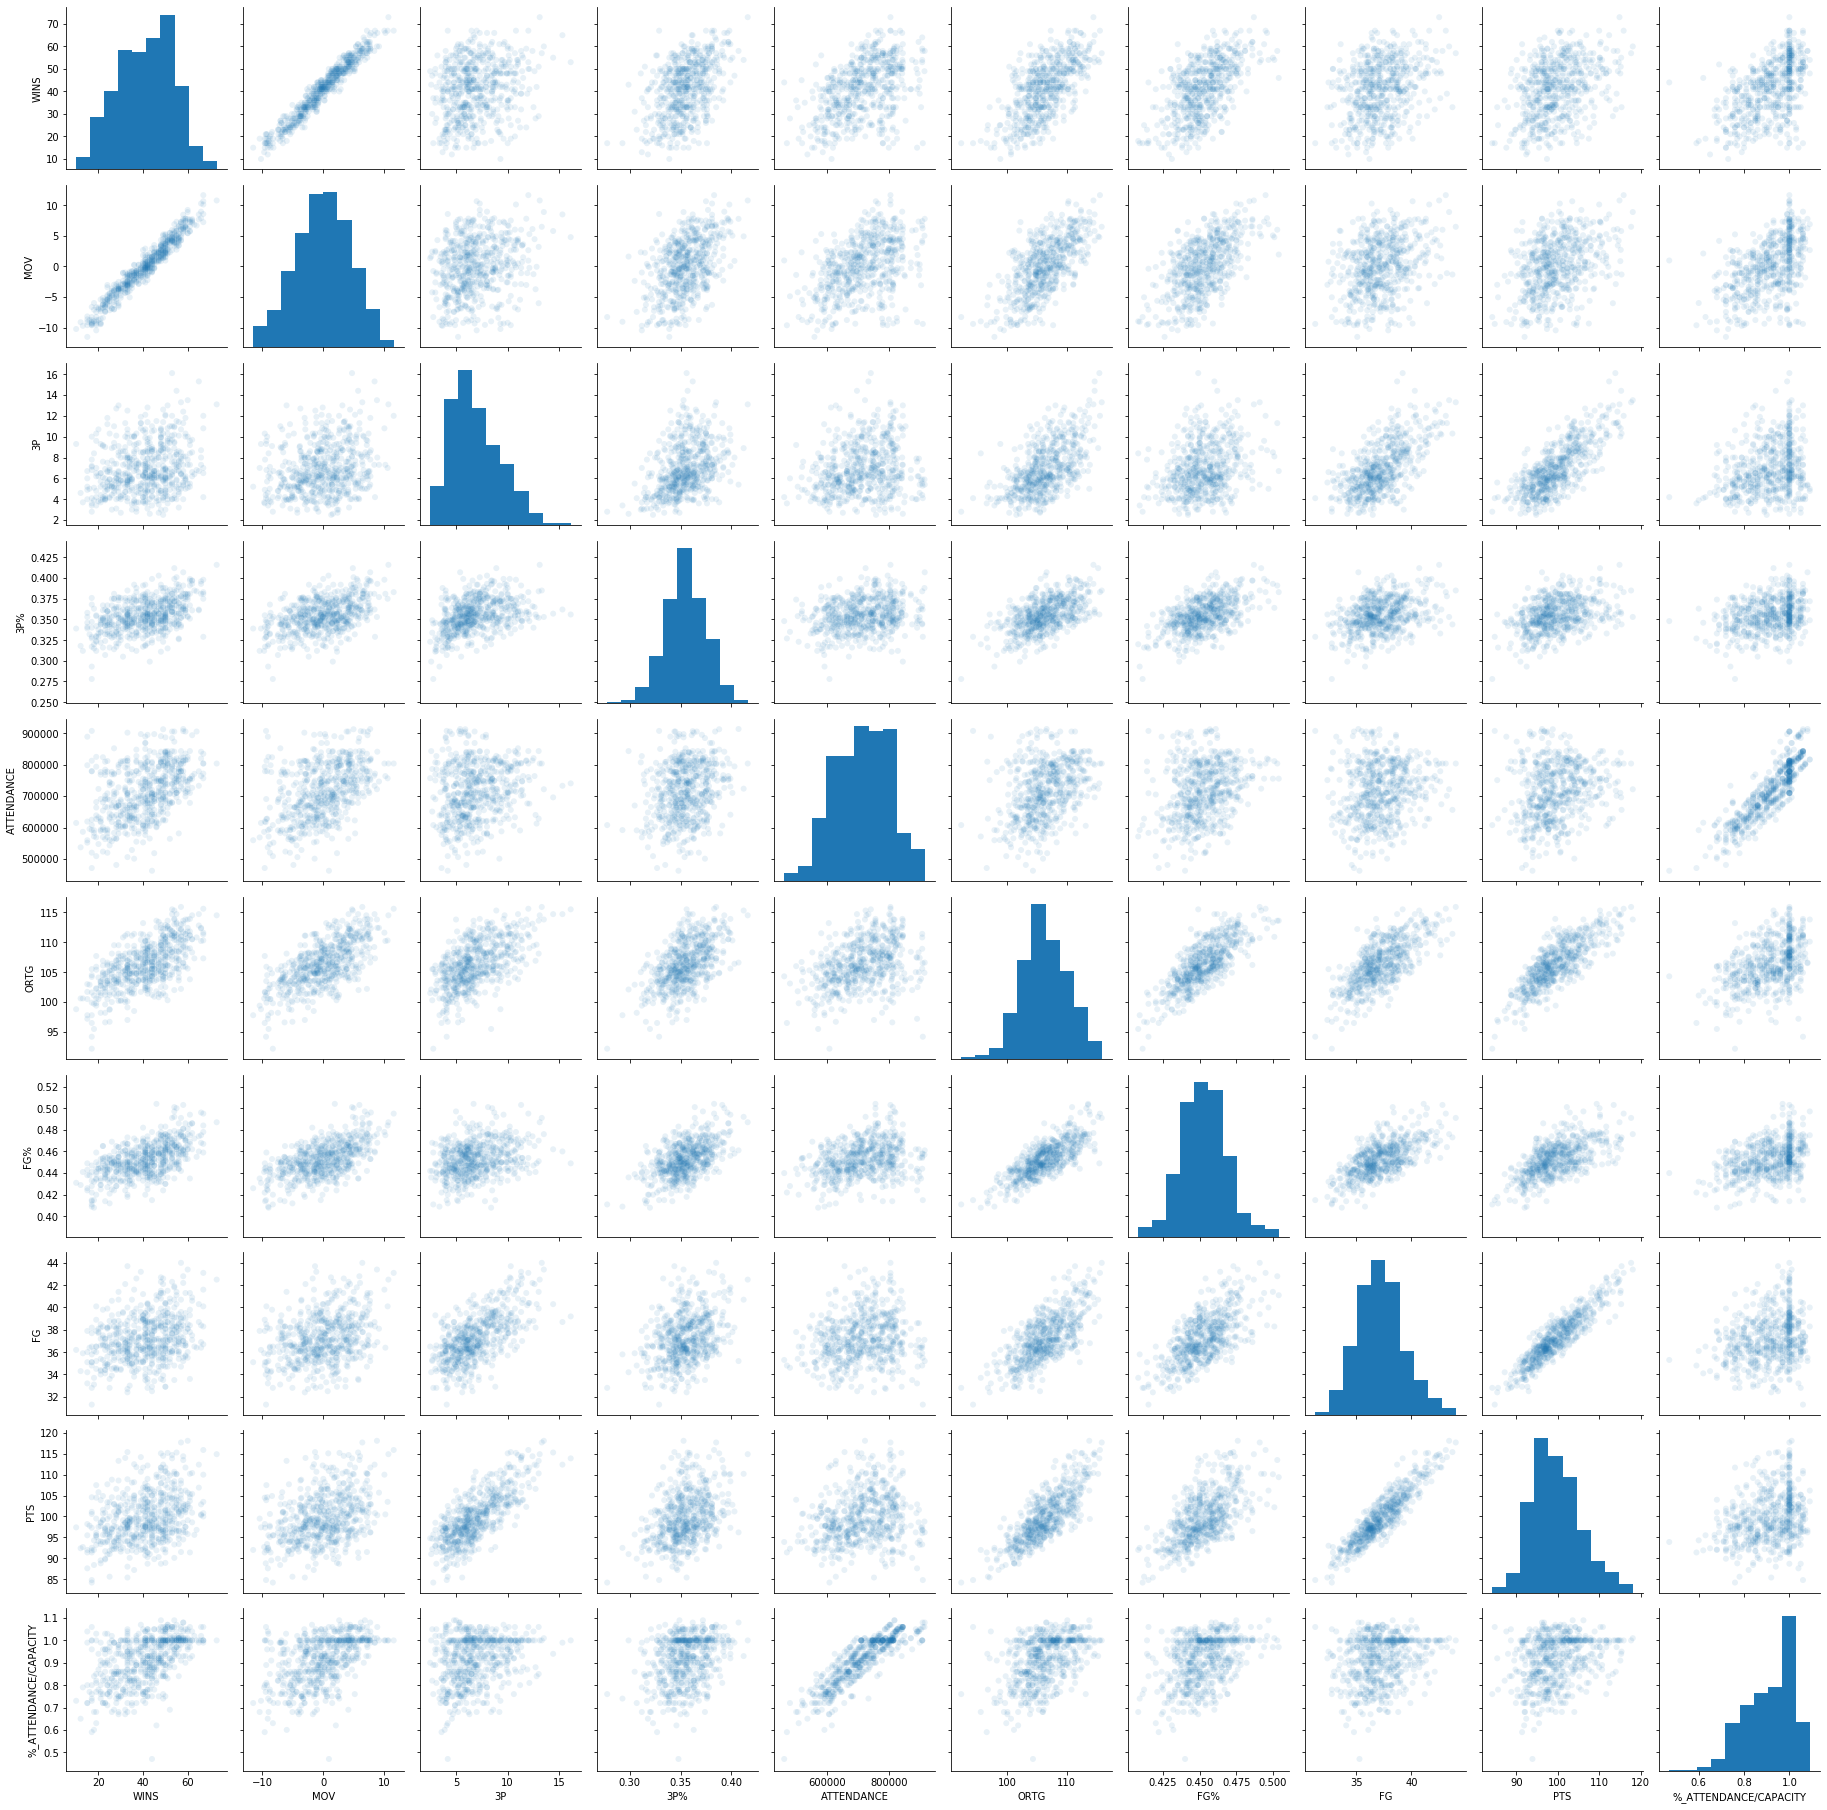

In [8]:
# On a visual level, attendance has no strong relationships with any of the features.

sns.pairplot(dk_nba_team_stats, plot_kws = dict(alpha = .1, edgecolor = 'none'))

## Post-Project Updates (Add in City Population as Feature)

In [9]:
city_population = pd.read_csv('city_pop.csv')

In [10]:
city_population

,Year,City,Population
0,2000,NYK,"8,015,348"
1,2000,LAL,"3,703,921"
2,2000,CHI,"2,895,671"
3,2000,HOU,"1,977,811"
4,2000,PHI,"1,513,800"
...,...,...,...
19027,2015,BRK,"8,550,405"
19028,2016,BRK,"8,537,673"
19029,2017,BRK,"8,622,698"
19030,2018,BRK,"8,398,748"


In [11]:
city_population['Population'] = city_population['Population'].str.replace(',', '')

In [12]:
city_population['Population'] = city_population['Population'].astype(int)

In [13]:
city_population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19032 entries, 0 to 19031
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Year        19032 non-null  int64 
 1   City        19032 non-null  object
 2   Population  19032 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 446.2+ KB


In [14]:
nba_team_stats['CITY_POP'] = 0

Added each city's population to the NBA Team Stats DF.

In [15]:
for index, each_row in city_population.iterrows():
    for nba_index, nba_row in nba_team_stats.iterrows():
        if each_row['Year'] == nba_team_stats.loc[nba_index, 'Year']:
            if each_row['City'] == nba_team_stats.loc[nba_index, 'Team']:
                nba_team_stats.loc[nba_index, 'CITY_POP'] = each_row['Population']

### Building a Baseline

In [16]:
# First, let's split the dataset into our training/val (2000-2015), 80% of total.

nba_train_val = nba_team_stats[(nba_team_stats['Year'] != 2016) & (nba_team_stats['Year'] != 2017) & (nba_team_stats['Year'] != 2018) & (nba_team_stats['Year'] != 2019)]
print(len(nba_train_val))
    
# and testing (2016-2019), 20% of total.

nba_testing = nba_team_stats[(nba_team_stats['Year'] == 2016) | (nba_team_stats['Year'] == 2017) | (nba_team_stats['Year'] == 2018) | (nba_team_stats['Year'] == 2019)]
print(len(nba_testing))
    

445
120


In [18]:
# We will use our domain knowledge of features to generate our baseline model.

X = nba_train_val[{'FG','FG%', '3P', '3P%', 'PTS', 'WINS', 'MOV', 'ORTG', 'CAPACITY'}]

y = nba_train_val['%_ATTENDANCE/CAPACITY']

Wrote a function that we can call on to split and validate our training/val dataset to calculate our R-Squared.

In [257]:
def split_and_validate(X,y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 24)
    
    # Fit the linear regression to the training data
    linreg = LinearRegression()
    
    # Fit data into standard scaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    linreg.fit(X_train_scaled, y_train)
    
    
    
    # Score the fit model on training data
    train_score = cross_val_score(linreg, X_train_scaled, y_train, cv = 5, scoring = 'r2').mean()
    print('Linear Regression Training Score:', train_score)
    
    # Score the fit model on validation data
    val_score = cross_val_score(linreg, X_val_scaled, y_val, cv = 5, scoring = 'r2').mean()
    print('Linear Regression Validation Score:', val_score)
    
    print('\nFeature Coefficients: \n')
    for feature, coef in zip(X.columns, linreg.coef_):
        print(feature, ':', f'{coef:.2f}')
    
    # Predicted Values
    pred = linreg.predict(X_val_scaled)
    
    df = pd.DataFrame({'Actual': y_val, 'Predicted': pred})
    
    chart = sns.scatterplot(pred, y_val-pred)
    
    chart.axes.axhline(y = 0, color = 'black')
    # Plot Residuals
#     res = y_train - pred
#     plt.scatter(pred, res)
#     plt.title('Residual Plot')
#     plt.xlabel('Prediction')
#     plt.ylabel('Residuals')

Baseline Model Results:

Linear Regression Training Score: 0.31785961942742436
Linear Regression Validation Score: 0.07936131743389878

Feature Coefficients: 

WINS : 0.07
MOV : -0.03
3P : 0.01
3P% : -0.00
ORTG : 0.03
FG% : 0.02
FG : -0.01
PTS : -0.02
CAPACITY : -0.00


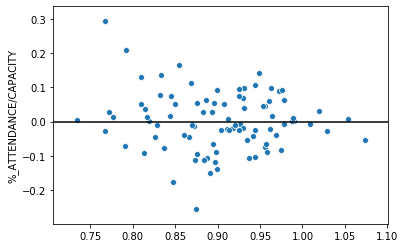

In [258]:
print('Baseline Model Results:\n')
split_and_validate(X,y)

### Adding Features 1 - Difference Between Attendance Years

It's become observable that the R-Squared is simply too low. We will have to add in new features that would yield us better, stronger results. The first one I want to add is the difference of attendance between each year for each team. 

Because some of the teams have rebranded themselves or have moved locations over the years, we will update the following past team names to the most recent names, but leave the stadium columns alone.

- NJN FROM 2010-2012, **BRK** 2013-2020
- CHH 2000-2002, NOH (2003-2005, 2008-2013), NOK (2006-2007) **NOP** 2014-2020 
- CHA FROM 2004-2014, **CHO** 2015-2020 
- VAN FROM 2000-2001, **MEM** 2001-2020
- SEA FROM 2000-2008, **OKC** 2008-2020

Due to CHH (Charlotte Hornets) moving to New Orleans, I am considering that team to be part of the NOP. CHA (Charlotte Bobcats) will be referred to as CHO in the current time period.

Let's go ahead and update those names.


In [21]:
# NJN - BRK
nba_team_stats['Team'] = nba_team_stats['Team'].replace('NJN', 'BRK')

# CHH, NOH, NOK - NOP
nba_team_stats['Team'] = nba_team_stats['Team'].replace('CHH', 'NOP')
nba_team_stats['Team'] = nba_team_stats['Team'].replace('NOH', 'NOP')
nba_team_stats['Team'] = nba_team_stats['Team'].replace('NOK', 'NOP')

# CHA - CHO
nba_team_stats['Team'] = nba_team_stats['Team'].replace('CHA', 'CHO')

# VAN - MEM
nba_team_stats['Team'] = nba_team_stats['Team'].replace('VAN', 'MEM')

# SEA - OKC
nba_team_stats['Team'] = nba_team_stats['Team'].replace('SEA', 'OKC')

Awesome, now, let's go ahead and create the difference between last year's attendance with the current year's attendance for each row.

In [22]:
# Confirmed there are 30 teams now.

nba_team_stats['Team'].nunique()

30

In [23]:
nba_team_stats = nba_team_stats.sort_values(by = ['Team','Year'])

In [24]:
nba_team_stats.head()

,Team,Year,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,OEFG%,OTOV%,ODRB%,OFT/FGA,ARENA,ATTENDANCE,CAPACITY,ATTENDANCE_PER_GAME,%_ATTENDANCE/CAPACITY,CITY_POP
190,ATL,2000,241.8,36.6,83.0,0.441,3.1,9.9,0.317,33.4,...,0.481,11.3,71.0,0.196,Philips Arena,600954,18118,14657,0.81,421323
191,ATL,2001,240.6,35.1,81.3,0.431,4.1,11.4,0.357,31.0,...,0.472,13.8,70.8,0.249,Philips Arena,560330,18118,13667,0.75,431321
192,ATL,2002,241.2,35.4,80.6,0.439,5.2,14.6,0.354,30.2,...,0.495,14.1,70.9,0.218,Philips Arena,506110,18118,12344,0.68,442947
193,ATL,2003,242.7,34.9,78.5,0.444,4.9,13.9,0.352,30.0,...,0.469,12.1,70.4,0.222,Philips Arena,528655,18118,12894,0.71,457068
194,ATL,2004,242.7,34.5,79.6,0.433,5.1,15.2,0.335,29.4,...,0.476,13.1,70.5,0.234,Philips Arena,565728,18118,13798,0.76,468839


In [25]:
nba_team_stats['DIFF_ATTENDANCE'] = nba_team_stats.groupby(['Team'])['ATTENDANCE'].diff().fillna(0)

In [26]:
nba_team_stats['DIFF_ATTENDANCE'] = nba_team_stats['DIFF_ATTENDANCE'].astype(int)

In [27]:
nba_team_stats

,Team,Year,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,OTOV%,ODRB%,OFT/FGA,ARENA,ATTENDANCE,CAPACITY,ATTENDANCE_PER_GAME,%_ATTENDANCE/CAPACITY,CITY_POP,DIFF_ATTENDANCE
190,ATL,2000,241.8,36.6,83.0,0.441,3.1,9.9,0.317,33.4,...,11.3,71.0,0.196,Philips Arena,600954,18118,14657,0.81,421323,0
191,ATL,2001,240.6,35.1,81.3,0.431,4.1,11.4,0.357,31.0,...,13.8,70.8,0.249,Philips Arena,560330,18118,13667,0.75,431321,-40624
192,ATL,2002,241.2,35.4,80.6,0.439,5.2,14.6,0.354,30.2,...,14.1,70.9,0.218,Philips Arena,506110,18118,12344,0.68,442947,-54220
193,ATL,2003,242.7,34.9,78.5,0.444,4.9,13.9,0.352,30.0,...,12.1,70.4,0.222,Philips Arena,528655,18118,12894,0.71,457068,22545
194,ATL,2004,242.7,34.5,79.6,0.433,5.1,15.2,0.335,29.4,...,13.1,70.5,0.234,Philips Arena,565728,18118,13798,0.76,468839,37073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,WAS,2015,243.4,38.3,82.8,0.462,6.1,16.8,0.360,32.2,...,12.9,77.3,0.210,Verizon Center,747796,20356,18239,0.90,672228,49728
243,WAS,2016,240.9,39.5,85.8,0.460,8.6,24.2,0.358,30.8,...,14.6,77.7,0.218,Verizon Center,725426,20356,17693,0.87,681170,-22370
244,WAS,2017,242.1,41.3,87.0,0.475,9.2,24.8,0.372,32.1,...,13.8,75.5,0.213,Verizon Center,697107,20356,17003,0.84,693972,-28319
245,WAS,2018,242.1,39.9,85.6,0.467,9.9,26.5,0.375,30.0,...,13.6,77.1,0.212,Capital One Arena,739302,20356,18032,0.89,702455,42195


In [28]:
# Let's include the 'DIFF_ATTENDANCE' in our validation and testing dataset.

nba_train_val = nba_team_stats[(nba_team_stats['Year'] != 2016) & (nba_team_stats['Year'] != 2017) & (nba_team_stats['Year'] != 2018) & (nba_team_stats['Year'] != 2019)]
print(len(nba_train_val))
    
# and testing (2016-2019), 20% of total.

nba_testing = nba_team_stats[(nba_team_stats['Year'] == 2016) | (nba_team_stats['Year'] == 2017) | (nba_team_stats['Year'] == 2018) | (nba_team_stats['Year'] == 2019)]
print(len(nba_testing))
    

445
120


We called our split and validate function to get the R-Squared scores for the added new feature.

In [29]:
X1 = nba_train_val[{'FG','FG%', '3P', '3P%', 'PTS', 'WINS', 'MOV', 'ORTG', 'CAPACITY', 'DIFF_ATTENDANCE'}]

y1 = nba_train_val['%_ATTENDANCE/CAPACITY']

Linear Regression Training Score: 0.3140121512793363
Linear Regression Validation Score: 0.10841136932934892

Feature Coefficients: 

WINS : 0.05
MOV : -0.02
3P : 0.01
3P% : -0.00
DIFF_ATTENDANCE : 0.02
ORTG : 0.03
FG% : 0.02
FG : -0.01
PTS : -0.02
CAPACITY : -0.00


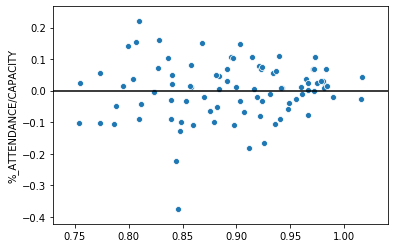

In [259]:
split_and_validate(X1, y1)

### Adding Features 2 - All-Stars Feature

The difference in attendance YOY paints us a better picture in the overall increases/decreases of a specific team. But seeing how the stats did not play a large influence in improving our R-Squared score, let's look at adding a new feature: the amount of all-stars on a team. 

All-Stars are generally the most popular NBA players in the league, as they are voted in by a combination of fans (50%), current players (25%), and basketball media (25%). If a team has more all-stars, could this prove to be a higher attendance rate?

In [31]:
all_stars = pd.read_csv('nba_all_stars.csv')

In [32]:
# Let's create an empty column within the nba_stats_team dataframe to hold num of all stars

nba_team_stats['NUM_OF_ALLSTARS'] = 0

In [33]:
nba_team_stats.head()

,Team,Year,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,ODRB%,OFT/FGA,ARENA,ATTENDANCE,CAPACITY,ATTENDANCE_PER_GAME,%_ATTENDANCE/CAPACITY,CITY_POP,DIFF_ATTENDANCE,NUM_OF_ALLSTARS
190,ATL,2000,241.8,36.6,83.0,0.441,3.1,9.9,0.317,33.4,...,71.0,0.196,Philips Arena,600954,18118,14657,0.81,421323,0,0
191,ATL,2001,240.6,35.1,81.3,0.431,4.1,11.4,0.357,31.0,...,70.8,0.249,Philips Arena,560330,18118,13667,0.75,431321,-40624,0
192,ATL,2002,241.2,35.4,80.6,0.439,5.2,14.6,0.354,30.2,...,70.9,0.218,Philips Arena,506110,18118,12344,0.68,442947,-54220,0
193,ATL,2003,242.7,34.9,78.5,0.444,4.9,13.9,0.352,30.0,...,70.4,0.222,Philips Arena,528655,18118,12894,0.71,457068,22545,0
194,ATL,2004,242.7,34.5,79.6,0.433,5.1,15.2,0.335,29.4,...,70.5,0.234,Philips Arena,565728,18118,13798,0.76,468839,37073,0


In [34]:
all_stars.head()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2013,2014,2015,2016,2017,2018,2019
0,MIN,LAL,LAL,MIN,LAL,LAL,PHO,LAL,SAS,LAL,DEN,OKC,OKC,OKC,HOU,GSW,NOP,CLE,LAL
1,PHI,PHI,PHI,PHI,IND,PHI,MIA,CLE,ORL,ORL,CLE,MIA,NYK,CLE,CLE,TOR,TOR,HOU,GSW
2,PHO,PHO,SAS,SAS,MIN,HOU,HOU,HOU,DEN,NOH,DAL,LAL,LAL,MIN,GSW,LAL,HOU,GSW,HOU
3,TOR,TOR,WAS,ORL,PHI,CLE,CLE,MIA,CLE,CLE,MIA,CHI,MIA,MIA,NYK,IND,MIL,TOR,MIL
4,SAS,SAC,MIN,LAL,SAS,HOU,LAL,DAL,DEN,PHO,PHO,NOH,LAC,LAC,MEM,SAS,GSW,OKC,GSW


In [35]:
test1 = nba_team_stats[nba_team_stats['Team'] == 'LAL']
test1.head()

,Team,Year,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,ODRB%,OFT/FGA,ARENA,ATTENDANCE,CAPACITY,ATTENDANCE_PER_GAME,%_ATTENDANCE/CAPACITY,CITY_POP,DIFF_ATTENDANCE,NUM_OF_ALLSTARS
342,LAL,2000,241.5,38.3,83.4,0.459,4.2,12.8,0.329,34.1,...,73.1,0.222,STAPLES Center,771420,18997,18815,0.99,3703921,0,0
343,LAL,2001,242.7,37.9,81.5,0.465,5.4,15.5,0.344,32.6,...,72.5,0.234,STAPLES Center,776336,18997,18935,1.00,3737646,4916,0
344,LAL,2002,241.2,38.4,83.4,0.461,6.2,17.5,0.354,32.2,...,72.0,0.233,STAPLES Center,778777,18997,18995,1.00,3768763,2441,0
345,LAL,2003,243.0,37.7,83.6,0.451,5.9,16.7,0.356,31.8,...,72.7,0.241,STAPLES Center,777888,18997,18973,1.00,3787833,-889,0
346,LAL,2004,242.1,36.9,81.4,0.454,4.5,13.6,0.327,32.5,...,73.3,0.222,STAPLES Center,777757,18997,18970,1.00,3796018,-131,0


In [36]:
nba_team_stats.loc[0,'NUM_OF_ALLSTARS'] +=1

In [37]:
for each_year in all_stars:
    for teams in all_stars[each_year]:
        for index, each_row in nba_team_stats.iterrows():
            if nba_team_stats.loc[index]['Team'] == teams:
                if nba_team_stats.loc[index]['Year'] == int(each_year):
                    nba_team_stats.loc[index, 'NUM_OF_ALLSTARS'] += 1

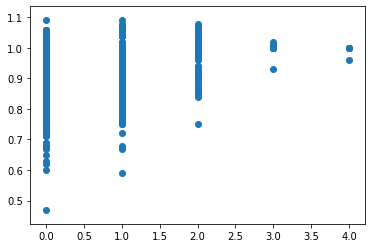

In [38]:
plt.scatter(nba_team_stats['NUM_OF_ALLSTARS'], nba_team_stats['%_ATTENDANCE/CAPACITY'])

In [39]:
# Let's include the 'NUM_OF_ALLSTARS' in our validation and testing dataset.

nba_train_val = nba_team_stats[(nba_team_stats['Year'] != 2016) & (nba_team_stats['Year'] != 2017) & (nba_team_stats['Year'] != 2018) & (nba_team_stats['Year'] != 2019)]
print(len(nba_train_val))
    
# and testing (2016-2019), 20% of total.

nba_testing = nba_team_stats[(nba_team_stats['Year'] == 2016) | (nba_team_stats['Year'] == 2017) | (nba_team_stats['Year'] == 2018) | (nba_team_stats['Year'] == 2019)]
print(len(nba_testing))
    

445
120


We call our split and validate function with the addition of the number of all stars feature.

In [40]:
X2 = nba_train_val[{'FG','FG%', '3P', '3P%', 'PTS', 'WINS', 'CAPACITY',
                                    'MOV', 'ORTG','DIFF_ATTENDANCE', 'NUM_OF_ALLSTARS'}]

y2 = nba_train_val['%_ATTENDANCE/CAPACITY']

Linear Regression Training Score: 0.3192217281100893
Linear Regression Validation Score: 0.11328436564244179

Feature Coefficients: 

WINS : 0.05
MOV : -0.02
NUM_OF_ALLSTARS : 0.01
3P : 0.00
3P% : -0.00
DIFF_ATTENDANCE : 0.02
ORTG : 0.03
FG% : 0.02
FG : -0.01
PTS : -0.02
CAPACITY : -0.00


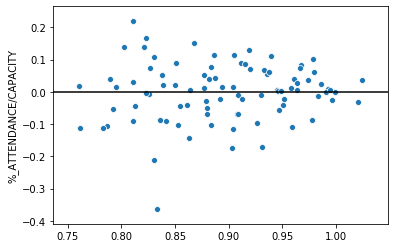

In [260]:
split_and_validate(X2, y2)

### Adding Features 3 - Number of Championships?

Could it be the prestige? The team with more rings mean more attendance?

In [42]:
nba_championships = pd.read_csv('nba_championships.csv')

In [43]:
nba_team_stats

,Team,Year,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,ODRB%,OFT/FGA,ARENA,ATTENDANCE,CAPACITY,ATTENDANCE_PER_GAME,%_ATTENDANCE/CAPACITY,CITY_POP,DIFF_ATTENDANCE,NUM_OF_ALLSTARS
190,ATL,2000,241.8,36.6,83.0,0.441,3.1,9.9,0.317,33.4,...,71.0,0.196,Philips Arena,600954,18118,14657,0.81,421323,0,1
191,ATL,2001,240.6,35.1,81.3,0.431,4.1,11.4,0.357,31.0,...,70.8,0.249,Philips Arena,560330,18118,13667,0.75,431321,-40624,1
192,ATL,2002,241.2,35.4,80.6,0.439,5.2,14.6,0.354,30.2,...,70.9,0.218,Philips Arena,506110,18118,12344,0.68,442947,-54220,1
193,ATL,2003,242.7,34.9,78.5,0.444,4.9,13.9,0.352,30.0,...,70.4,0.222,Philips Arena,528655,18118,12894,0.71,457068,22545,0
194,ATL,2004,242.7,34.5,79.6,0.433,5.1,15.2,0.335,29.4,...,70.5,0.234,Philips Arena,565728,18118,13798,0.76,468839,37073,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,WAS,2015,243.4,38.3,82.8,0.462,6.1,16.8,0.360,32.2,...,77.3,0.210,Verizon Center,747796,20356,18239,0.90,672228,49728,1
243,WAS,2016,240.9,39.5,85.8,0.460,8.6,24.2,0.358,30.8,...,77.7,0.218,Verizon Center,725426,20356,17693,0.87,681170,-22370,1
244,WAS,2017,242.1,41.3,87.0,0.475,9.2,24.8,0.372,32.1,...,75.5,0.213,Verizon Center,697107,20356,17003,0.84,693972,-28319,1
245,WAS,2018,242.1,39.9,85.6,0.467,9.9,26.5,0.375,30.0,...,77.1,0.212,Capital One Arena,739302,20356,18032,0.89,702455,42195,1


In [44]:
nba_championships.head()

,Teams,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,LAL,12,13,14,14,14,14,14,14,14,...,16,16,16,16,16,16,16,16,16,16
1,BOS,16,16,16,16,16,16,16,16,17,...,17,17,17,17,17,17,17,17,17,17
2,GSW,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,4,4,5,6,6
3,CHI,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
4,SAS,1,1,1,2,2,3,3,4,4,...,4,4,4,4,5,5,5,5,5,5


In [45]:
nba_team_stats['CHAMPIONSHIPS'] = 0

In [46]:
for each_year in nba_championships.columns[1:]:
    for index, each_row in nba_team_stats.iterrows():
        for num_rows in range(19):
            if nba_team_stats.loc[index]['Team'] == nba_championships['Teams'][num_rows]:
                if nba_team_stats.loc[index]['Year'] == int(each_year):
                    nba_team_stats.loc[index, 'CHAMPIONSHIPS'] = nba_championships[each_year][num_rows]
                

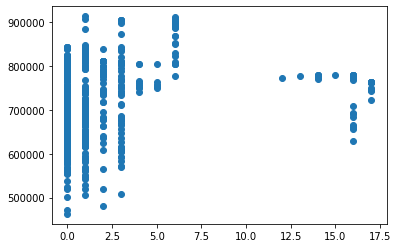

In [47]:
plt.scatter(nba_team_stats['CHAMPIONSHIPS'], nba_team_stats['ATTENDANCE'])

In [48]:
nba_team_stats['CHAMPIONSHIPS'].unique()

array([ 1, 16, 17,  0,  6,  2,  3,  4,  5, 12, 13, 14, 15])

In [49]:
# Let's include the 'CHAMPIONSHIPS' in our validation and testing dataset.

nba_train_val = nba_team_stats[(nba_team_stats['Year'] != 2016) & (nba_team_stats['Year'] != 2017) & (nba_team_stats['Year'] != 2018) & (nba_team_stats['Year'] != 2019)]
print(len(nba_train_val))
    
# and testing (2016-2019), 20% of total.

nba_testing = nba_team_stats[(nba_team_stats['Year'] == 2016) | (nba_team_stats['Year'] == 2017) | (nba_team_stats['Year'] == 2018) | (nba_team_stats['Year'] == 2019)]
print(len(nba_testing))
    

445
120


We call our split and validate function with the addition of the championships feature.

In [50]:
X3 = nba_train_val[{'FG','FG%', '3P', '3P%', 'PTS', 'WINS', 'CHAMPIONSHIPS', 'CAPACITY',
                                    'MOV', 'ORTG', 'DIFF_ATTENDANCE', 'NUM_OF_ALLSTARS'}]

y3 = nba_train_val['%_ATTENDANCE/CAPACITY']

Linear Regression Training Score: 0.34801098891728605
Linear Regression Validation Score: 0.12158504480571915

Feature Coefficients: 

WINS : 0.05
MOV : -0.02
NUM_OF_ALLSTARS : 0.01
3P : 0.00
3P% : -0.00
DIFF_ATTENDANCE : 0.02
ORTG : 0.04
FG% : 0.02
CHAMPIONSHIPS : 0.02
FG : -0.01
PTS : -0.02
CAPACITY : -0.00


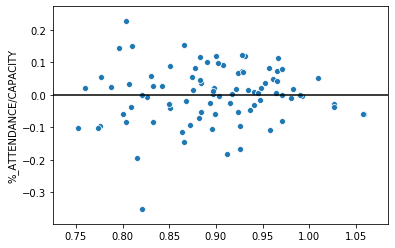

In [261]:
split_and_validate(X3,y3)

Created a polynomial and lasso function that will help us determine whether they would give us a better score than our current multiple linear regression models.

In [266]:
def poly_split_and_validate(X,y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 24)
    
    # Fit the linear regression to the training data
    linreg = LinearRegression()
    
    
    # Fit into StandardScaler before feeding into Polynomial
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    linreg.fit(X_train_scaled, y_train)
    
    
    
    # Score the fit model on training data
    train_score = cross_val_score(linreg, X_train_scaled, y_train, cv = 5, scoring = 'r2').mean()
    print('Linear Regression Training Score:', train_score)
    
    # Score the fit model on validation data
    val_score = cross_val_score(linreg, X_val_scaled, y_val, cv = 5, scoring = 'r2').mean()
    print('Linear Regression Validation Score:', val_score)
    
    # Call a Polynomial Regression Object.
    p = PolynomialFeatures(degree=2)
    x_train_poly = p.fit_transform(X_train_scaled)
    x_val_poly = p.transform(X_val_scaled)
    
    linreg.fit(x_train_poly,y_train)
    print('\n2-Degree Polynomial Training Score:', linreg.score(x_train_poly,y_train))
    print('2-Degree Polynomial Validation Score:', linreg.score(x_val_poly, y_val))
    
    # Call a Lasso Regularization Object.
    lasso_model = LassoCV()
    lasso_model.fit(X_train_scaled, y_train)
    
    scores = cross_validate(lasso_model, X_train_scaled, y_train, cv = 5, return_train_score = True)
    print('\nLasso Model Training Score:', np.mean(scores['train_score']))
    print('Lasso Model Validation Score:', np.mean(scores['test_score']))
    
    
    return list(zip(X_train.columns,lasso_model.coef_)) 

In [267]:
poly_split_and_validate(X3, y3)

Linear Regression Training Score: 0.34801098891728605
Linear Regression Validation Score: 0.12158504480571915

2-Degree Polynomial Training Score: 0.6752893047286312
2-Degree Polynomial Validation Score: 0.3610071373109449

Lasso Model Training Score: 0.412168237467322
Lasso Model Validation Score: 0.3565565376640499


[('WINS', 0.030241624001360823),
 ('MOV', 0.0),
 ('NUM_OF_ALLSTARS', 0.007620943403886453),
 ('3P', -0.0),
 ('3P%', 0.0),
 ('DIFF_ATTENDANCE', 0.01570230749323106),
 ('ORTG', 0.027577449285950864),
 ('FG%', 0.011597580434638675),
 ('CHAMPIONSHIPS', 0.015570038873707386),
 ('FG', -0.005461643166379817),
 ('PTS', -0.013279333986467077),
 ('CAPACITY', -0.0028060402364338015)]

### Adding Features 4 - Arena Change?

With stadiums constantly being changed, and some NBA teams rebranding themselves, do they, perhaps have a influence on the attendance flow?

- NJN FROM 2000-2012, **BRK** 2013-2020 - Did a location move cause any attendance change?
- CHH 2000-2002, NOH (2003-2005, 2008-2013), NOK (2006-2007) **NOP** 2014-2020 - Rebranding cause attendance change?
- CHA FROM 2004-2014, **CHO** 2015-2020 - Rebranding cause ttendance change?
- VAN FROM 2000-2001, **MEM** 2001-2020
- SEA FROM 2000-2008, **OKC** 2008-2020

In [58]:
# Arena Change/Rebrand = 1, No Change = 0

In [59]:
nba_team_stats[nba_team_stats['Team'] == 'HOU'].head()

,Team,Year,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,OFT/FGA,ARENA,ATTENDANCE,CAPACITY,ATTENDANCE_PER_GAME,%_ATTENDANCE/CAPACITY,CITY_POP,DIFF_ATTENDANCE,NUM_OF_ALLSTARS,CHAMPIONSHIPS
475,HOU,2000,241.8,36.6,81.3,0.450,7.1,19.8,0.358,29.5,...,0.201,Compaq Center,624594,16285,15234,0.94,1977811,0,0,2
476,HOU,2001,241.8,35.9,79.2,0.453,6.1,17.2,0.357,29.7,...,0.206,Compaq Center,518555,16285,12648,0.78,1994316,-106039,0,2
477,HOU,2002,243.7,34.6,80.8,0.428,6.0,18.0,0.335,28.5,...,0.178,Compaq Center,481227,16285,11737,0.72,2012297,-37328,1,2
478,HOU,2003,243.0,34.6,78.8,0.440,5.4,15.5,0.346,29.3,...,0.209,Compaq Center,565166,16285,13785,0.85,2032955,83939,2,2
479,HOU,2004,243.0,33.4,75.5,0.442,6.3,17.1,0.366,27.1,...,0.233,Toyota Center,640794,18055,15629,0.87,2058645,75628,2,2


In [60]:
nba_team_stats['PREVIOUS_ARENA'] = nba_team_stats.groupby(['Team'])['ARENA'].apply(lambda grp: grp.shift(1))

#nba_team_stats['ARENA_CHANGE'] = nba_team_stats.groupby(['Team'])['ATTENDANCE'].diff().fillna(0)

In [61]:
# Construct a new column to hold Arena changes

nba_team_stats['ARENA_CHANGE'] = ""

In [62]:
for index, each_row in nba_team_stats.iterrows():
        if each_row['PREVIOUS_ARENA'] is np.nan:
            nba_team_stats.loc[index, 'ARENA_CHANGE'] = 0
            
        elif each_row['PREVIOUS_ARENA'] != each_row['ARENA']:
            nba_team_stats.loc[index, 'ARENA_CHANGE'] = 1
            
        else:
            nba_team_stats.loc[index, 'ARENA_CHANGE'] = 0


In [63]:
nba_team_stats.head()

,Team,Year,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,ATTENDANCE,CAPACITY,ATTENDANCE_PER_GAME,%_ATTENDANCE/CAPACITY,CITY_POP,DIFF_ATTENDANCE,NUM_OF_ALLSTARS,CHAMPIONSHIPS,PREVIOUS_ARENA,ARENA_CHANGE
190,ATL,2000,241.8,36.6,83.0,0.441,3.1,9.9,0.317,33.4,...,600954,18118,14657,0.81,421323,0,1,1,NaN,0
191,ATL,2001,240.6,35.1,81.3,0.431,4.1,11.4,0.357,31.0,...,560330,18118,13667,0.75,431321,-40624,1,1,Philips Arena,0
192,ATL,2002,241.2,35.4,80.6,0.439,5.2,14.6,0.354,30.2,...,506110,18118,12344,0.68,442947,-54220,1,1,Philips Arena,0
193,ATL,2003,242.7,34.9,78.5,0.444,4.9,13.9,0.352,30.0,...,528655,18118,12894,0.71,457068,22545,0,1,Philips Arena,0
194,ATL,2004,242.7,34.5,79.6,0.433,5.1,15.2,0.335,29.4,...,565728,18118,13798,0.76,468839,37073,0,1,Philips Arena,0


In [64]:
# Let's include the 'ARENA_CHANGE' in our validation and testing dataset.

nba_train_val = nba_team_stats[(nba_team_stats['Year'] != 2016) & (nba_team_stats['Year'] != 2017) & (nba_team_stats['Year'] != 2018) & (nba_team_stats['Year'] != 2019)]
print(len(nba_train_val))
    
# and testing (2016-2019), 20% of total.

nba_testing = nba_team_stats[(nba_team_stats['Year'] == 2016) | (nba_team_stats['Year'] == 2017) | (nba_team_stats['Year'] == 2018) | (nba_team_stats['Year'] == 2019)]
print(len(nba_testing))
    

445
120


We call our polynomial/lasso function to check the scores with the addition of the arena change feature.

In [65]:
# Let's add Arena Change as a feature.

X4 = nba_train_val[{'FG','FG%', '3P', '3P%', 'PTS', 'WINS', 'CHAMPIONSHIPS', 'CAPACITY',
                                    'ARENA_CHANGE','MOV', 'ORTG', 'DIFF_ATTENDANCE', 'NUM_OF_ALLSTARS'}]

y4 = nba_train_val['%_ATTENDANCE/CAPACITY']

In [268]:
poly_split_and_validate(X4,y4)

Linear Regression Training Score: 0.34759346461375495
Linear Regression Validation Score: 0.1165655139876081

2-Degree Polynomial Training Score: 0.7035084329627342
2-Degree Polynomial Validation Score: 0.23506877924807626

Lasso Model Training Score: 0.41528584907067767
Lasso Model Validation Score: 0.35604593891489167


[('WINS', 0.030140370181203486),
 ('MOV', 0.0),
 ('ARENA_CHANGE', -0.003942194755984195),
 ('3P', 0.0),
 ('3P%', 0.0),
 ('DIFF_ATTENDANCE', 0.016365010452213603),
 ('NUM_OF_ALLSTARS', 0.007527291971276232),
 ('ORTG', 0.027679690362706462),
 ('FG%', 0.011581906965004884),
 ('CHAMPIONSHIPS', 0.015480274634937483),
 ('FG', -0.005616916344192718),
 ('PTS', -0.01315193215128327),
 ('CAPACITY', -0.0032229419203654037)]

## POST PROJECT UPDATES: Adding External Data - Population.

After finishing our project and yielding low R-Squared results, I tackled my project by finding more data to populate as features that may have a stronger correlation with my target variable.

In [269]:
X_pop = nba_train_val[{'WINS', 'CHAMPIONSHIPS', 'CAPACITY', 'EFG%',
                                    'CITY_POP', 'DIFF_ATTENDANCE', 'NUM_OF_ALLSTARS'}]

y_pop = nba_train_val['%_ATTENDANCE/CAPACITY']

# Dropped 'FG','FG%', '3P', '3P%', 'PTS', 'ORTG', 'MOV'

In [270]:
poly_split_and_validate(X_pop,y_pop)

Linear Regression Training Score: 0.40616715284909677
Linear Regression Validation Score: 0.18073609105460192

2-Degree Polynomial Training Score: 0.5880210164711044
2-Degree Polynomial Validation Score: 0.4313603209524025

Lasso Model Training Score: 0.442439457791244
Lasso Model Validation Score: 0.40269511727569346


[('WINS', 0.044744657804674424),
 ('NUM_OF_ALLSTARS', 0.008824081079632297),
 ('EFG%', 0.010423590568226887),
 ('CHAMPIONSHIPS', 0.011284484997421766),
 ('CAPACITY', -0.008852731812571095),
 ('DIFF_ATTENDANCE', 0.016530973390808286),
 ('CITY_POP', 0.02664872580132164)]

WOW. Simply adding in the city populations yield a much higher Lasso Model Validation Score, from 5% to 41%! It also raised our 2-Degree Polynomial Training Score to 56%! 

\* Note that I did remove the 'Arena_Diff','FG','FG%', '3P', '3P%', 'PTS', 'ORTG' features, as these served low correlations with predicting my y-output values. I also removed MOV, since there was high multicollinearity (+95%) with WINS. I included EFG% when I noticed it had a correlation above 40% - I did not use the correlation matrix the first time around!

## POST PROJECT UPDATES: Adding External Data - Superstar Legacy.

There has been NBA players in the past that dominated the league and proved through that throught the tests of time, continue to have a lingering effect on the fans to come through. MJ on the Bulls, Showtime Lakers, are just some of the given superstar legacies. 

The way I will handle these features is by compiling a list of the top 100 players in the PER (Player Efficiency Rating) category of all time. I will combine domain knowledge and the PER list to decide which players or set of players had the largest impact on becoming the face of the franchise in catapulting their teams to popularity. 

- If a player played after 1995, we will add a +1 to the Superstar Legacy to the team that the player played the most seasons in. For teams that had superstars before 2000, we will apply a constant 1 throughout until 2019, since they still have an impact on which teams are deemed more popular than the others.

- If a player played before 1995, we will assign a 0 to the teams, since it will not be considered in recent memory to be still a popular franchise.

In [192]:
superstar_legacy = pd.read_csv('Superstar Legacy.csv')

In [194]:
nba_team_stats['SUPERSTAR_LEGACY'] = 0

In [195]:
for index, row in superstar_legacy.iterrows():
    for stats_index, stats_row in nba_team_stats.iterrows():
        if row['Team'] == stats_row['Team']:
            if row['Year'] == stats_row['Year']:
                nba_team_stats.loc[stats_index, 'SUPERSTAR_LEGACY'] = row['Legacy Superstar']

In [199]:
nba_train_val = nba_team_stats[(nba_team_stats['Year'] != 2016) & (nba_team_stats['Year'] != 2017) & (nba_team_stats['Year'] != 2018) & (nba_team_stats['Year'] != 2019)]
print(len(nba_train_val))
    
# and testing (2016-2019), 20% of total.

nba_testing = nba_team_stats[(nba_team_stats['Year'] == 2016) | (nba_team_stats['Year'] == 2017) | (nba_team_stats['Year'] == 2018) | (nba_team_stats['Year'] == 2019)]
print(len(nba_testing))

445
120


In [200]:
X_super = nba_train_val[{'WINS', 'CHAMPIONSHIPS', 'CAPACITY', 'EFG%', 'SUPERSTAR_LEGACY',
                                    'CITY_POP', 'DIFF_ATTENDANCE', 'NUM_OF_ALLSTARS'}]

y_super = nba_train_val['%_ATTENDANCE/CAPACITY']

In [271]:
poly_split_and_validate(X_super, y_super)

Linear Regression Training Score: 0.5335637407321625
Linear Regression Validation Score: 0.40658726798776

2-Degree Polynomial Training Score: 0.6872349027109999
2-Degree Polynomial Validation Score: 0.6526546547992516

Lasso Model Training Score: 0.5672138592168816
Lasso Model Validation Score: 0.5328899474048694


[('WINS', 0.03739940345162912),
 ('NUM_OF_ALLSTARS', 0.008959200578775113),
 ('SUPERSTAR_LEGACY', 0.040951700839221075),
 ('EFG%', 0.005360175667528095),
 ('CHAMPIONSHIPS', 0.005667628452586655),
 ('CAPACITY', -0.013829426075351387),
 ('DIFF_ATTENDANCE', 0.017407420217789793),
 ('CITY_POP', 0.017357177598896514)]

It's quite clear that once we added the super star legacy feature, we see a substantial improvement in all of our scores.

## Test: Superstar Legacy with Limited Features.

In [275]:
X_super_alone = nba_train_val[{'SUPERSTAR_LEGACY', 'WINS', 'CAPACITY', 'CITY_POP', 'NUM_OF_ALLSTARS'
                                    }]

y_super_alone = nba_train_val['%_ATTENDANCE/CAPACITY']

In [276]:
poly_split_and_validate(X_super_alone, y_super_alone)

Linear Regression Training Score: 0.5181443287787769
Linear Regression Validation Score: 0.33279612548228477

2-Degree Polynomial Training Score: 0.5993097043444919
2-Degree Polynomial Validation Score: 0.6036174820417246

Lasso Model Training Score: 0.5380880314760411
Lasso Model Validation Score: 0.517905278492672


[('WINS', 0.04291875855949809),
 ('NUM_OF_ALLSTARS', 0.011876230465694552),
 ('SUPERSTAR_LEGACY', 0.041519882197330035),
 ('CAPACITY', -0.014867103828464753),
 ('CITY_POP', 0.019064276725733832)]

It's even more obvious that if we only included the overall wins, the arena capacity, the city population, the number of all stars on a team, the superstar legacy features and removed all the in-game advanced stats - we yield a higher score than before! 

## FINAL TEST (No City Pop/Superstar Legacy)

In [205]:
nba_train_val = nba_team_stats[(nba_team_stats['Year'] != 2016) & (nba_team_stats['Year'] != 2017) & (nba_team_stats['Year'] != 2018) & (nba_team_stats['Year'] != 2019)]
print(len(nba_train_val))
    
# and testing (2016-2019), 20% of total.

nba_testing = nba_team_stats[(nba_team_stats['Year'] == 2016) | (nba_team_stats['Year'] == 2017) | (nba_team_stats['Year'] == 2018) | (nba_team_stats['Year'] == 2019)]
print(len(nba_testing))
    

445
120


In [241]:
X_final_pre = nba_train_val[{'FG','FG%', '3P', '3P%', 'PTS', 'WINS', 'CHAMPIONSHIPS', 'CAPACITY',
                                    'ARENA_CHANGE','MOV', 'ORTG', 'DIFF_ATTENDANCE', 'NUM_OF_ALLSTARS'}]

y_final_pre = nba_train_val['%_ATTENDANCE/CAPACITY']

In [242]:
X4_test_pre = nba_testing[{'FG','FG%', '3P', '3P%', 'PTS', 'WINS', 'CHAMPIONSHIPS', 'CAPACITY',
                                    'ARENA_CHANGE','MOV', 'ORTG', 'DIFF_ATTENDANCE', 'NUM_OF_ALLSTARS'}]

y4_test_pre = nba_testing['%_ATTENDANCE/CAPACITY']

Linear Regression Training Score: 0.34759346461375495
Linear Regression Validation Score: 0.1165655139876081
Linear Regression Validation Score: -0.3289650784502559

2-Degree Polynomial Training Score: 0.7035084329627342
2-Degree Polynomial Validation Score: 0.23506877924807626
2-Degree Polynomial Test Score: -1.1753849443686981


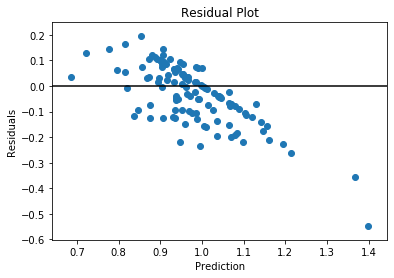

In [251]:
test_final_validation(X_final_pre, y_final_pre, X4_test_pre, y4_test_pre)

In [277]:
# Let's add Arena Change as a feature.

X_final = nba_train_val[{'WINS', 'CAPACITY', 'SUPERSTAR_LEGACY', 'NUM_OF_ALLSTARS',
                                    'CITY_POP'}]

y_final = nba_train_val['%_ATTENDANCE/CAPACITY']

In [280]:
X4_test = nba_testing[{'WINS', 'CAPACITY', 'SUPERSTAR_LEGACY','NUM_OF_ALLSTARS',
                                    'CITY_POP'}]

y4_test = nba_testing['%_ATTENDANCE/CAPACITY']

In [281]:
def test_final_validation(X_train_val,y_train_val, X_test, y_test):
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 24)

    # Fit the linear regression to the training data
    linreg = LinearRegression()  
    
    # Scale X train, X val, and X test
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    linreg.fit(X_train_scaled, y_train)
    
        
    # Score the fit model on training data
    train_score = cross_val_score(linreg, X_train_scaled, y_train, cv = 5, scoring = 'r2').mean()
    print('Linear Regression Training Score:', train_score)
    
    # Score the fit model on validation data
    val_score = cross_val_score(linreg, X_val_scaled, y_val, cv = 5, scoring = 'r2').mean()
    print('Linear Regression Validation Score:', val_score)
    
    # Score the fit model on testing data
    test_score = cross_val_score(linreg, X_test_scaled, y_test, cv = 5, scoring = 'r2').mean()
    print('Linear Regression Validation Score:', test_score)
    
#     print('\nFeature Coefficients: \n')
#     for feature, coef in zip(X.columns, linreg.coef_):
#         print(feature, ':', f'{coef:.2f}')
        
    
    p = PolynomialFeatures(degree=2)
    x_train_poly = p.fit_transform(X_train_scaled)
    x_val_poly = p.transform(X_val_scaled)
    x_test_poly = p.transform(X_test_scaled)
    
    
    linreg.fit(x_train_poly,y_train)
    print('\n2-Degree Polynomial Training Score:', linreg.score(x_train_poly,y_train))
    print('2-Degree Polynomial Validation Score:', linreg.score(x_val_poly, y_val))
    print('2-Degree Polynomial Test Score:', linreg.score(x_test_poly, y_test))
    print(mean_absolute_error(y_test, linreg.predict(x_test_poly)))

    lasso_model = LassoCV(max_iter = 10000)
    lasso_model.fit(x_train_poly, y_train)
    
    scores = cross_validate(lasso_model, x_train_poly, y_train, cv = 7, return_train_score = True)
    print('\nLasso Model Training Score:', np.mean(scores['train_score']))
    print('Lasso Model Validation Score:', np.mean(scores['test_score']))
    
    # Calculate r2 on final test
    
    final_score = cross_validate(lasso_model, x_test_poly, y_test, cv = 7, return_train_score = True)
    print('Lasso Model Test Score:', np.mean(final_score['test_score']))
    
    
    
#     plt.figure(figsize = (15,5))
#     chart = sns.scatterplot(p.get_feature_names(['FG','FG%', '3P', '3P%', 'PTS', 'WINS', 'CHAMPIONSHIPS','ARENA_CHANGE',
#                         'CAPACITY','MOV', 'ORTG','DIFF_ATTENDANCE', 'NUM_OF_ALLSTARS']), linreg.coef_)
#     chart.set_xticklabels(X_train.columns, rotation = 45)
#     chart.axes.axhline(y = 0, color = 'black')
#     plt.title('Coefficients by Feature, Test Data')
#     plt.ylabel('Model Coefficients')
#     plt.xlabel('Features')
    #pred = lasso_model.predict(X_test_scaled)
    
    #return list(zip(p.get_feature_names(X_train.columns),linreg.coef_))
    #sns.pairplot(x_vars = pred, y_vars = y_test, data = X, kind = 'reg')
#     #Plot Residuals
    pred = linreg.predict(x_test_poly)
    res = y_test - pred
    chart = plt.scatter(pred, res)
    chart.axes.axhline(y = 0, color = 'black')
    plt.title('Residual Plot')
    plt.xlabel('Prediction')
    plt.ylabel('Residuals')

    #sns.scatterplot(lasso_model.predict(X_train_scaled)

Linear Regression Training Score: 0.5181443287787769
Linear Regression Validation Score: 0.33279612548228477
Linear Regression Validation Score: 0.1481720196341339

2-Degree Polynomial Training Score: 0.5993097043444919
2-Degree Polynomial Validation Score: 0.6036174820417246
2-Degree Polynomial Test Score: 0.5188978647385255
0.04354053044319153

Lasso Model Training Score: 0.5926044873926049
Lasso Model Validation Score: 0.5296720472111426
Lasso Model Test Score: -0.10180635173062046


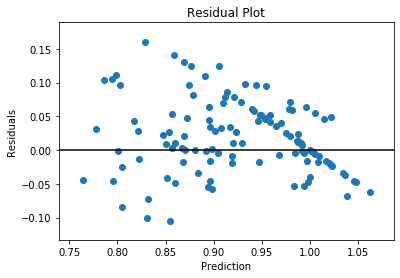

In [282]:
test_final_validation(X_final, y_final, X4_test, y4_test)

### EXTRAS FOR PRESENTATION

Text(0.5, 1.0, 'CLE Year vs % Attendance/Capacity')

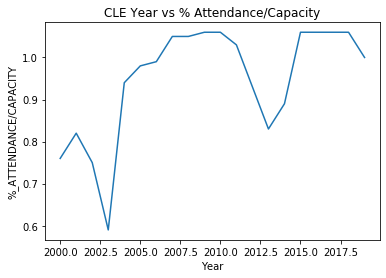

In [283]:
sns.lineplot(nba_team_stats[nba_team_stats['Team'] == 'CLE']['Year'], nba_team_stats[nba_team_stats['Team'] == 'CLE']['%_ATTENDANCE/CAPACITY'] )
plt.title('CLE Year vs % Attendance/Capacity')

Text(0.5, 1.0, 'CLE Year vs Number of All-Stars')

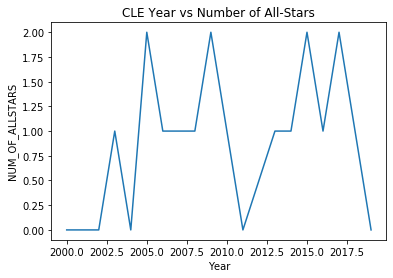

In [284]:
sns.lineplot(nba_team_stats[nba_team_stats['Team'] == 'CLE']['Year'], nba_team_stats[nba_team_stats['Team'] == 'CLE']['NUM_OF_ALLSTARS']) 
plt.title('CLE Year vs Number of All-Stars')